In [1]:
import enefit
import pandas as pd
from datetime import datetime
import statistics
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
# pulling in data
trainingData = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/train.csv");
clientData = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/client.csv");
elecPriceData = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv");
foreWeatherData = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv");
gasPriceData = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv");
histWeatherData = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv");
weatherToCountyMap = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv");

In [3]:
# common variables
datetimeColName = 'datetime'
timeColName = 'time'
date_time_format = '%Y-%m-%d %H:%M:%S'
time_format = '%H'
date_format = '%Y-%m-%d'

In [4]:
# sorting training data by time from datetime column
trainingDataSortedByTime = trainingData.copy()
def func(row):
    timeStamp = datetime.strptime(row[datetimeColName], date_time_format)
    return int(timeStamp.strftime(time_format))

trainingDataSortedByTime[timeColName] = trainingDataSortedByTime.apply(func, axis=1)
trainingDataSortedByTime = trainingDataSortedByTime.sort_values(timeColName)
trainingDataSortedByTime = trainingDataSortedByTime.reset_index(drop=True)

<Axes: xlabel='time'>

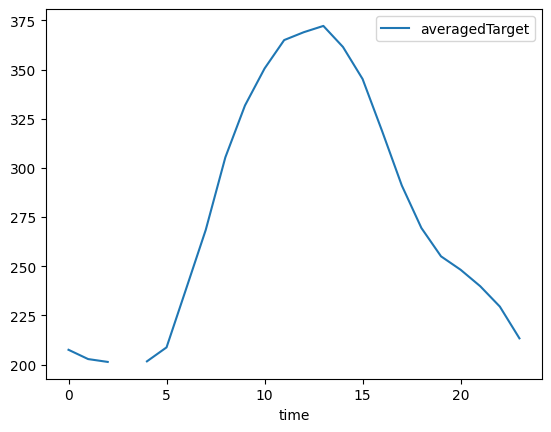

In [5]:
# averages of target consumption/production for all counties across the day
averagedData = pd.DataFrame(columns=[timeColName, 'averagedTarget'])

rowIndex = 0
while rowIndex < len(trainingDataSortedByTime):
    timeStamp = trainingDataSortedByTime['time'][rowIndex]
    endRowIndex = rowIndex
    while endRowIndex < len(trainingDataSortedByTime) and trainingDataSortedByTime['time'][endRowIndex] == timeStamp:
        endRowIndex += 1
    average = statistics.mean(trainingDataSortedByTime['target'][rowIndex:endRowIndex])
    newRow = [{timeColName:timeStamp, 'averagedTarget': average}]
    averagedData = pd.concat([averagedData, pd.DataFrame(newRow)], ignore_index=True)
    rowIndex = endRowIndex

averagedData.plot(x=timeColName, y='averagedTarget', style='-')

# Summary
## Prosumption increases during the day, peaking at midday/just after. Lowest at night particularly between midnight and 4am

In [6]:
# compare forecasted gas prices to consumption/production on that day -- 
chooseConsumption = 1
totalConsumption = pd.DataFrame(columns=[datetimeColName, 'totalConsumption', 'averagedConsumption'])
trainingDataConsumptionData = trainingData.copy()

trainingDataConsumptionData = trainingDataConsumptionData.drop(trainingDataConsumptionData[trainingDataConsumptionData['is_consumption'] == (not chooseConsumption)].index)

def func(row):
    timeStamp = datetime.strptime(row[datetimeColName], date_time_format)
    return timeStamp.strftime(date_format)

trainingDataConsumptionData[datetimeColName] = trainingDataConsumptionData.apply(func, axis=1)

trainingDataConsumptionData = trainingDataConsumptionData.sort_values(datetimeColName)
trainingDataConsumptionData = trainingDataConsumptionData.reset_index(drop=True)

rowIndex = 0
while rowIndex < len(trainingDataConsumptionData):
    timeStamp = trainingDataConsumptionData[datetimeColName][rowIndex]
    endRowIndex = rowIndex
    while endRowIndex < len(trainingDataConsumptionData) and trainingDataConsumptionData[datetimeColName][endRowIndex] == timeStamp:
        endRowIndex += 1
    average = statistics.mean(trainingDataConsumptionData['target'][rowIndex:endRowIndex])
    totalCons = sum(trainingDataConsumptionData['target'][rowIndex:endRowIndex])
    newRow = [{datetimeColName:timeStamp, 'totalConsumption': totalCons, 'averagedConsumption': average}]
    totalConsumption = pd.concat([totalConsumption, pd.DataFrame(newRow)], ignore_index=True)
    rowIndex = endRowIndex

In [7]:
print(gasPriceData['forecast_date'][0], totalConsumption['datetime'][0],gasPriceData['forecast_date'][len(gasPriceData)-1], totalConsumption['datetime'][len(totalConsumption)-2])
gasPriceData['datetime'] = gasPriceData.loc[:, 'forecast_date']
combinedData = totalConsumption.merge(gasPriceData,on='datetime')
# add the spread between lowest and highest price per mwh
combinedData['spread'] = combinedData['highest_price_per_mwh']-combinedData['lowest_price_per_mwh']
combinedData


2021-09-01 2021-09-01 2023-05-30 2023-05-30


,datetime,totalConsumption,averagedConsumption,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id,spread
0,2021-09-01,513929.956,351.045052,2021-09-01,45.23,46.32,2021-08-31,1,1.09
1,2021-09-02,518908.306,354.445564,2021-09-02,45.62,46.29,2021-09-01,2,0.67
2,2021-09-03,527919.770,360.600936,2021-09-03,45.85,46.40,2021-09-02,3,0.55
3,2021-09-04,373264.397,254.962020,2021-09-04,46.30,46.80,2021-09-03,4,0.50
4,2021-09-05,366969.576,250.662279,2021-09-05,46.30,46.58,2021-09-04,5,0.28
...,...,...,...,...,...,...,...,...,...
632,2023-05-26,615020.329,388.270410,2023-05-26,29.10,34.10,2023-05-25,633,5.00
633,2023-05-27,427683.894,270.002458,2023-05-27,28.30,34.10,2023-05-26,634,5.80
634,2023-05-28,415896.573,266.600367,2023-05-28,28.10,34.10,2023-05-27,635,6.00
635,2023-05-29,603023.774,386.553701,2023-05-29,28.16,36.98,2023-05-28,636,8.82


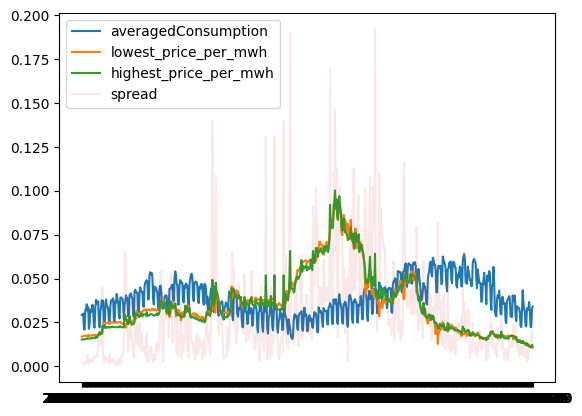

In [8]:
combinedData = combinedData.dropna()
plt.plot(combinedData['datetime'],preprocessing.normalize([combinedData['averagedConsumption']])[0], label = "averagedConsumption") 
plt.plot(combinedData['datetime'],preprocessing.normalize([combinedData['lowest_price_per_mwh']])[0], label = "lowest_price_per_mwh")
plt.plot(combinedData['datetime'],preprocessing.normalize([combinedData['highest_price_per_mwh']])[0], label = "highest_price_per_mwh")
plt.plot(combinedData['datetime'],preprocessing.normalize([combinedData['spread']])[0], label = "spread", alpha=0.1)
plt.legend(loc='best')
plt.show()

In [9]:
# correlation coefficient between gas price and consumption
print(combinedData['highest_price_per_mwh'].corr(combinedData['averagedConsumption']))
print(combinedData['lowest_price_per_mwh'].corr(combinedData['averagedConsumption']))
print(combinedData['highest_price_per_mwh'].corr(combinedData['totalConsumption']))
print(combinedData['lowest_price_per_mwh'].corr(combinedData['totalConsumption']))


-0.21522508531128107
-0.2547752979876287
-0.17852694916121845
-0.22138039743995128


# Summary:
## Weak negative correlation between forecasted gas prices and consumption. No correlation between forecasted gas prices and production.

In [10]:
# compare forecasted electricity prices to consumption/production at that time on that day -- 
chooseConsumption = 1
totalConsumption_hour = pd.DataFrame(columns=[datetimeColName, 'totalConsumption', 'averagedConsumption'])
trainingDataConsumptionData_hour = trainingData.copy()

trainingDataConsumptionData_hour = trainingDataConsumptionData_hour.drop(trainingDataConsumptionData_hour[trainingDataConsumptionData_hour['is_consumption'] == (not chooseConsumption)].index)

trainingDataConsumptionData_hour = trainingDataConsumptionData_hour.sort_values(datetimeColName)
trainingDataConsumptionData_hour = trainingDataConsumptionData_hour.reset_index(drop=True)

rowIndex = 0
while rowIndex < len(trainingDataConsumptionData_hour):
    timeStamp = trainingDataConsumptionData_hour[datetimeColName][rowIndex]
    endRowIndex = rowIndex
    while endRowIndex < len(trainingDataConsumptionData_hour) and trainingDataConsumptionData_hour[datetimeColName][endRowIndex] == timeStamp:
        endRowIndex += 1
    average = statistics.mean(trainingDataConsumptionData_hour['target'][rowIndex:endRowIndex])
    totalCons = sum(trainingDataConsumptionData_hour['target'][rowIndex:endRowIndex])
    newRow = [{datetimeColName:timeStamp, 'totalConsumption': totalCons, 'averagedConsumption': average}]
    totalConsumption_hour = pd.concat([totalConsumption_hour, pd.DataFrame(newRow)], ignore_index=True)
    rowIndex = endRowIndex

In [11]:
print(elecPriceData['forecast_date'][0], totalConsumption_hour['datetime'][0],elecPriceData['forecast_date'][len(elecPriceData)-1], totalConsumption_hour['datetime'][len(totalConsumption_hour)-2])
elecPriceData['datetime'] = elecPriceData.loc[:, 'forecast_date']
combinedData_elec_hour = totalConsumption_hour.merge(elecPriceData,on='datetime')
combinedData_elec_hour

2021-09-01 00:00:00 2021-09-01 00:00:00 2023-05-30 23:00:00 2023-05-31 22:00:00


,datetime,totalConsumption,averagedConsumption,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,19859.808,325.570623,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,19265.078,315.820951,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,19260.892,315.752328,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,19026.484,311.909574,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,19367.124,317.493836,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1
...,...,...,...,...,...,...,...
15281,2023-05-30 19:00:00,28250.057,434.616262,2023-05-30 19:00:00,82.10,2023-05-29 19:00:00,637
15282,2023-05-30 20:00:00,31242.566,480.654862,2023-05-30 20:00:00,150.85,2023-05-29 20:00:00,637
15283,2023-05-30 21:00:00,31889.139,490.602138,2023-05-30 21:00:00,82.10,2023-05-29 21:00:00,637
15284,2023-05-30 22:00:00,32268.265,496.434846,2023-05-30 22:00:00,82.09,2023-05-29 22:00:00,637


In [12]:
combinedData_elec_hour = combinedData_elec_hour.dropna()
combinedData_elec_hour['averagedConsumption_normalised'] = preprocessing.normalize([combinedData_elec_hour['averagedConsumption']])[0]
combinedData_elec_hour['euros_per_mwh_normalised'] = preprocessing.normalize([combinedData_elec_hour['euros_per_mwh']])[0]
combinedData_elec_hour

/tmp/ipykernel_19/158600603.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combinedData_elec_hour['averagedConsumption_normalised'] = preprocessing.normalize([combinedData_elec_hour['averagedConsumption']])[0]
/tmp/ipykernel_19/158600603.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combinedData_elec_hour['euros_per_mwh_normalised'] = preprocessing.normalize([combinedData_elec_hour['euros_per_mwh']])[0]


,datetime,totalConsumption,averagedConsumption,forecast_date,euros_per_mwh,origin_date,data_block_id,averagedConsumption_normalised,euros_per_mwh_normalised
0,2021-09-01 00:00:00,19859.808,325.570623,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1,0.005445,0.003772
1,2021-09-01 01:00:00,19265.078,315.820951,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1,0.005282,0.003625
2,2021-09-01 02:00:00,19260.892,315.752328,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1,0.005281,0.003562
3,2021-09-01 03:00:00,19026.484,311.909574,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1,0.005217,0.003543
4,2021-09-01 04:00:00,19367.124,317.493836,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1,0.005310,0.003606
...,...,...,...,...,...,...,...,...,...
15281,2023-05-30 19:00:00,28250.057,434.616262,2023-05-30 19:00:00,82.10,2023-05-29 19:00:00,637,0.007269,0.003348
15282,2023-05-30 20:00:00,31242.566,480.654862,2023-05-30 20:00:00,150.85,2023-05-29 20:00:00,637,0.008039,0.006151
15283,2023-05-30 21:00:00,31889.139,490.602138,2023-05-30 21:00:00,82.10,2023-05-29 21:00:00,637,0.008206,0.003348
15284,2023-05-30 22:00:00,32268.265,496.434846,2023-05-30 22:00:00,82.09,2023-05-29 22:00:00,637,0.008303,0.003347


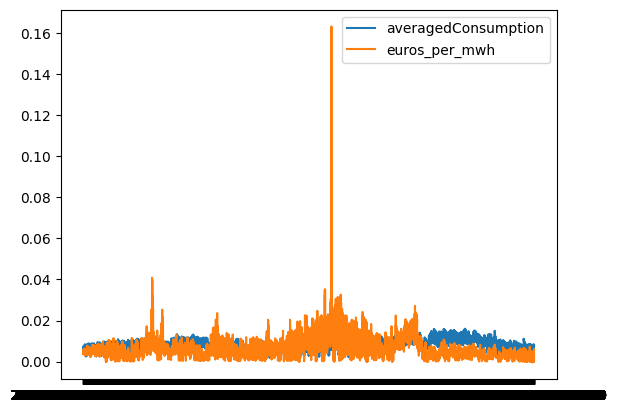

In [13]:
plt.plot(combinedData_elec_hour['datetime'],combinedData_elec_hour['averagedConsumption_normalised'], label = "averagedConsumption") 
plt.plot(combinedData_elec_hour['datetime'],combinedData_elec_hour['euros_per_mwh_normalised'], label = "euros_per_mwh")
plt.legend(loc='best')
plt.show()

In [14]:
# correlation coefficient between gas price and consumption
print(combinedData_elec_hour['euros_per_mwh_normalised'].corr(combinedData_elec_hour['averagedConsumption_normalised']))

0.21090358103322326


# Summary:
## Weak negative correlation between forecasted electricity prices and consumption. No correlation between forecasted electricity prices and production.